## ecom.tech ноутбук к соревнованию по NLP-задачи мульти-лейбл классификации отзывов о доставке. Часть 2 - Загрузка весов модели и выполнение предсказаний

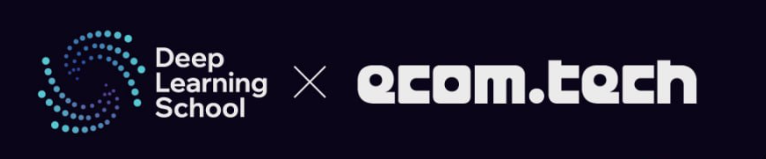

**Важно!**

Опять же, **обязательно** изменить пути к уже тестовым данным и файлу с описанием классов - пункт ноутбука `Обработка данных`. Далее обязательно изменить путь до весов `best`-версии модели, которые были получены в предыдущем ноутбуке, посвящённому дообучению модели.

Не стоит сразу же нажимать на `Выполнить всё`. Советую выполнять ячейки поэтапно, попутно читая всю информацию. Спасибо.

P.S.: если вдруг что-то пойдёт не так или не хочется снова грузить видеокарту, то я дополнительно выложил в репозиторий ссылку на модель, которая была обучена по предыдущему ноутбуку. Можно скачать её и смело использовать в данном ноутбуке.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import warnings
import os
import random

from transformers import RobertaTokenizer, RobertaForSequenceClassification

RANDOM_STATE = 42
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(seed):
    '''Зафиксируем случайности'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_STATE)

Следующий код запускает подключение Google Drive. Закомментировать строчку, если он не потребуется.

In [ ]:
# подключение Google Drive, где лежат данные
from google.colab import drive
drive.mount('/content/drive')

# Загрузка тестовых данных

Загрузим наши тестовые данные и выделим текст, убрав остальные признаки.

In [ ]:
descrs = pd.read_csv('/content/drive/MyDrive/ecom-tech/trends_description.csv')

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/ecom-tech/test.csv')
test_df = test_df.drop(['assessment', 'tags', 'Unnamed: 0'], axis=1)

In [ ]:
test_df_index = test_df['index'].copy()
test_df = test_df.drop('index', axis=1)
test_df['text'] = test_df['text'].fillna('')

In [ ]:
test_df.head()

# Выполнение прогноза

Объявим наш токенайзер, класс датасета и класс модели.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('ai-forever/ruRoberta-large')

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.text = list(df['text'])
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'text': text
        }

        return item

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 32

new_test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
new_test_data_loader = torch.utils.data.DataLoader(
    new_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
    )

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.bert_model = RobertaForSequenceClassification.from_pretrained(
            'ai-forever/ruRoberta-large',
            return_dict=True,
            problem_type='multi_label_classification',
            num_labels=50
        )

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )

        return output.logits

model = BERTClass().to(device)

**Важно!**

Напоминаю, что здесь нужно изменить путь до весов `best`-версии модели, которая получена в ходе обучения на предыдущем ноутбуке.

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ecom-tech/ruroberta-ecom-tech-best.pth', map_location=device))

In [ ]:
def get_new_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for data in data_loader:
            text = data["text"]
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).detach().cpu()

            preds = (outputs >= 0.45)

            texts.extend(text)
            predictions.extend(preds)
            prediction_probs.extend(outputs)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)

    return texts, predictions, prediction_probs

Запускаем составление прогнозов модели на тестовых данных соревнования.

In [ ]:
texts, predictions, prediction_probs = get_new_predictions(model, new_test_data_loader)

взгялнем на любой наш случайный объект и посмотрим, какие классы выставила ему наша модель.

In [ ]:
index = 0

print(' text:', texts[index], '\n\n', 'preds:', ', '.join(descrs.iloc[np.where(predictions[index] == 1)[0]].trend.values.tolist()))

Составим форму для `sumbission.csv` и сохраним наши прогнозы в файл.

Опять же, следует изменить путь до сохранения файла с прогнозами.

In [ ]:
result = {
    'index': test_df_index,
    'target': [' '.join(np.where(predictions[index] == 1)[0].astype(str).tolist()) for index in range(test_df.shape[0])]}

In [ ]:
pd.DataFrame(result).to_csv('ecom_submission_final_7.csv', index=False)

# Итоги

Всех благодарю за работу и организацию интересного соревнования! Отдельная благодарность Таесу за быструю и точную обратную связь, а так же за создание позитива в чате. Буду рад участвовать в дальнейших чемпионатах. Здорово было бы увидеть соревнование по компьютерному зрению и рекомендательным системам.

До новых встреч!